# Creation of the dataset
In this notebook we will use the pipeline developed by the master thesis Trufanova, for the realization of the dataset.
We will start from the training reference notebook to run the train of the first model and to download the dataset automatically if it is not present in the reference path.

In [1]:
import json
import os, sys, random
from sys import platform
import siibra
import nibabel as nib
from nilearn import plotting, datasets, image
import numpy as np
import matplotlib.pyplot as plt
from monai.utils import set_determinism

# importing file 
from alzheimer_disease.src.modules.postprocessing import get_gradcam, get_affected_areas, write_json_prompt
from alzheimer_disease.src.helpers.prompts import get_prompt
from alzheimer_disease.src.modules.explainability import get_explanations
import alzheimer_disease.src.modules.plotting as plot
from alzheimer_disease.src.helpers.utils import make_dataset, get_device
from alzheimer_disease.src.modules.training import train_test_splitting, training_model, predict_model
from alzheimer_disease.src.helpers.config import get_config
from alzheimer_disease.src.modules.preprocessing import get_transformations
from alzheimer_disease.src.models.densenetmm import DenseNetMM

# I use two paths as I’m using an external hard disk to not occupy the memory of the laptop,
# in case you want to work on the same device, change the directories
_base_path = '/Volumes/Seagate Bas/Vito/CV'

sys.path.append(_base_path)

[siibra:INFO] Version: 1.0a09
[siibra:WARNING] This is a development release. Use at your own risk.
[siibra:INFO] Please file bugs and issues at https://github.com/FZJ-INM1-BDA/siibra-python.


check if the dataset is downloaded and if it is not present in the specified directory, re-load it

In [2]:
data_path, meta_path = make_dataset(dataset='oasis_aug', base_path=_base_path)


> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 


DATA_PATH:  /Volumes/Seagate Bas/Vito/CV/data/oasis_aug/data
META_PATH:  /Volumes/Seagate Bas/Vito/CV/data/oasis_aug/meta

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 



In [3]:
_config = get_config()
saved_path = os.path.join(_base_path, _config.get('SAVED_FOLDER'))
reports_path = os.path.join(_base_path, _config.get('REPORT_FOLDER'))
logs_path = os.path.join(_base_path, _config.get('LOG_FOLDER'))
if platform == 'win32':
	saved_path = saved_path.replace('/', '\\')
	reports_path = reports_path.replace('/', '\\')
	logs_path = logs_path.replace('/', '\\')
		
saved_path, reports_path, logs_path

('/Volumes/Seagate Bas/Vito/CV/saved/',
 '/Volumes/Seagate Bas/Vito/CV/reports/',
 '/Volumes/Seagate Bas/Vito/CV/logs/')

As the colleague does, we set the seed to make the experiment deterministic

In [4]:
set_determinism(seed=3)
random.seed(3)

Definition of the features

In [5]:
SIZE = 128
CHANNELS = ['T2w']

FEATURES = ['age', 'ethnicity', 'education', 'weight', 'height', 'brain_disease', 'heart_disease', 'depression', 'sleeping_disorder', 'motor_disturbance']
MULTICLASS = True

Definition of model

In [6]:
dense_net_model = DenseNetMM(
		in_channels = len(CHANNELS),
		in_size = SIZE,
		in_features_size= len(FEATURES),
		out_channels = 3 if MULTICLASS else 2,
		append_features = True
	)

train test split

In [7]:
train_data, eval_data, test_data = train_test_splitting(
	data_folder=data_path,
	meta_folder=meta_path,
	channels=CHANNELS,
	features=FEATURES,
	multiclass=MULTICLASS,
	load_from_file=False,
	reports_path=reports_path,
	write_to_file=True
)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

                    TRAINING            EVALUATION          TESTING             

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

subjects            375 (64.0 %)        94 (16.0 %)         116 (20.0 %)        

sessions            435 (63.6 %)        113 (16.52 %)       136 (19.88 %)       



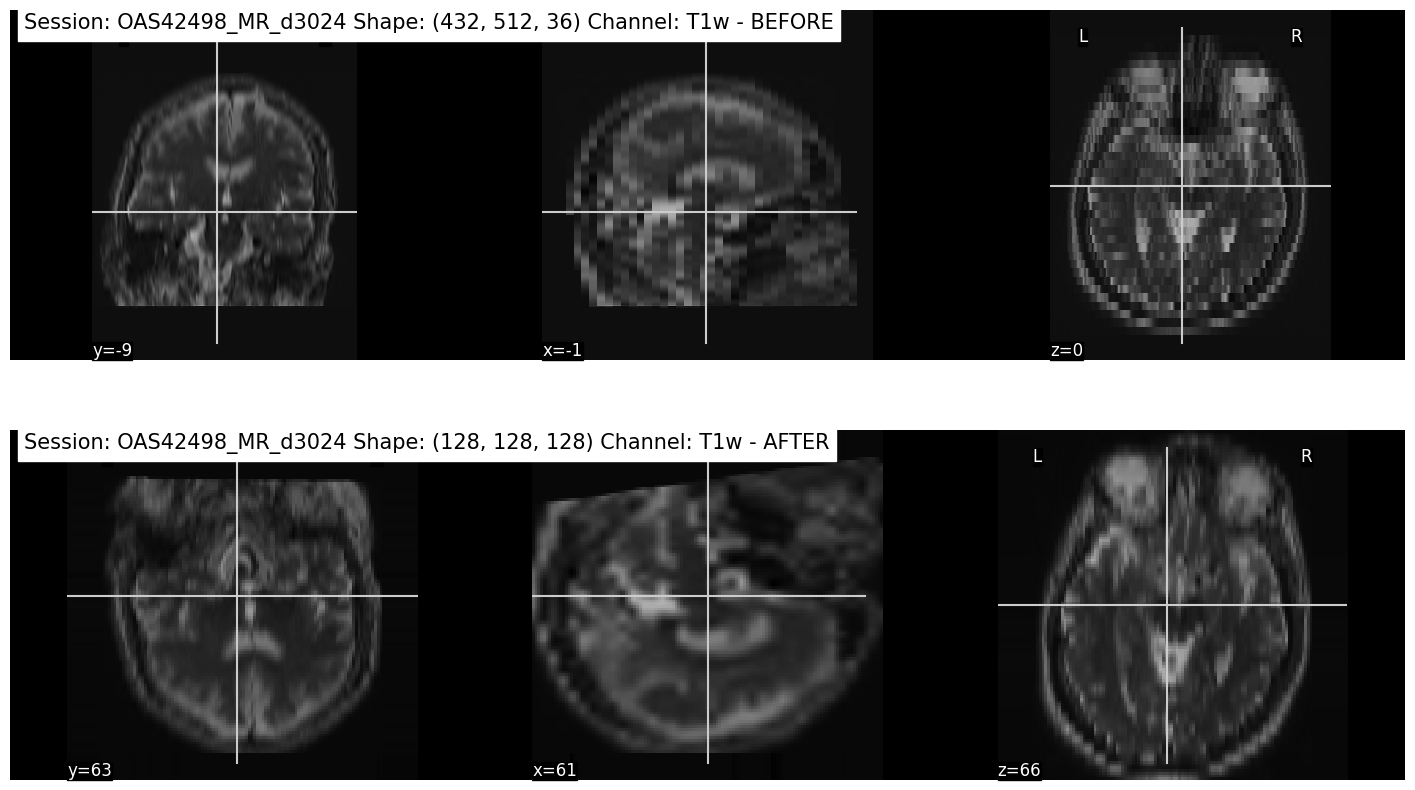

In [8]:
train_transform, eval_transform = get_transformations(size=SIZE)
plot.image_transformations(train_data)

In [9]:
train_metrics = training_model(
 	model = dense_net_model,
	data = [train_data, eval_data],
	transforms = [train_transform, eval_transform],
	epochs = 10,
	device = get_device(),
	paths = [saved_path, reports_path, logs_path],
	num_workers=0,
	verbose=True
)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
epoch 1/10
1/43, train_loss: 1.1089, step time: 0:01:11


KeyboardInterrupt: 

In [ ]:
plot.training_values(reports_path)

In [ ]:
test_metrics = predict_model(
	model = dense_net_model,
	data = test_data,
	transforms = eval_transform,
	device = get_device(),
	paths = [saved_path, reports_path, logs_path],
	num_workers=0,
	verbose=True
)

In [ ]:
plot.results_multiclass(reports_path)

The second imported notebook is the post-processing

In [ ]:
json_path = os.path.join(_base_path, _config.get('JSON_FOLDER'))
json_path

In [ ]:
atlas = siibra.atlases['human']
parcellations = list(atlas.parcellations)

In [ ]:
print(''.join(['> ' for i in range(40)]))
print(f'\n{"INDEX":<8}{"PARCELLATIONS NAME":<20}\n')
print(''.join(['> ' for i in range(40)]))
for i, p in enumerate(parcellations):
	print(f'{i:<8}{p.name:<20}')

In [ ]:
example = test_data[0]
example_name = example['image'][0].split('/')[-2]
input_img, mask, pred = get_gradcam(example, dense_net_model, saved_path, threshold=.8, plot_results=True)

In [ ]:
mni_template = datasets.load_mni152_template()
heat = nib.Nifti1Image(mask, affine=mni_template.affine)
bg = nib.Nifti1Image(input_img, affine=mni_template.affine)
heat_norm = image.resample_to_img(heat, mni_template)
points = siibra.PointSet(tuple(zip(*np.where(heat_norm.get_fdata() == 1))), space='mni152', sigma_mm=5).transform(mni_template.affine, space='mni152')
if len(points):
	plotting.view_markers(list(map(tuple, points)), marker_color='red', marker_size=1, title='TC (Tumor Core)')

In [ ]:
areas = get_affected_areas(
	parcellation=parcellations[12].name,
	volume=points,
	top=5,
	verbose=False
)

In [ ]:
write_json_prompt(
	example=example['image'][0].split('/')[-2],
	areas=areas,
	prediction=pred,
	json_path=json_path
)

In [ ]:
julich_pmaps = siibra.get_map(
	parcellation=siibra.parcellations.get(parcellations[12].name),
	space=siibra.spaces.get('mni152'),
	maptype=siibra.MapType.LABELLED
)
for a in areas:
	fig = plt.figure(figsize=(18, 6))
	plotting.plot_roi(
		roi_img=julich_pmaps.fetch(region=a),
		bg_img=mni_template,
		title=a,
		cmap='viridis',
		black_bg=False,
		figure=fig
	)
	plotting.show()

The last imported notebook is the explainability

In [ ]:
prompt_path = os.path.join(_base_path, _config.get('PROMPT_FOLDER'))

In [ ]:
_config = get_config()
_prompt = get_prompt()
json_path = os.path.join(_base_path, _config.get('JSON_FOLDER'))
if platform == 'win32':
	json_path = json_path.replace('/', '\\')
	prompt_path = prompt_path.replace('/', '\\')

In [ ]:
MODELS = {
	'biomistral': 'BioMistral/BioMistral-7B',
	'llama': 'meta-llama/Meta-Llama-3-8B-Instruct',
	'mistral': 'mistralai/Mistral-7B-Instruct-v0.2',
	'minerva': 'sapienzanlp/Minerva-1B-base-v1.0',
	'llamantino': 'swap-uniba/LLaMAntino-2-chat-7b-hf-UltraChat-ITA'
}

In [ ]:
LANG = 'IT'
MODEL_ID = MODELS.get('llama')
PROMPT = _prompt.get(LANG).get('prompt_2')

with open(os.path.join(json_path, 'OAS30031_MR_d0427_' + LANG.upper() + '.json'), 'r') as f:
	d = json.load(f)
	PROMPT += str(d)

In [ ]:
output = get_explanations(
	model_id = MODEL_ID,
	prompt = PROMPT,
	write_to_file = True,
	output_path = os.path.join(prompt_path, LANG.lower()),
	output_length = 1024,
	verbose = False
)